In [2]:
import findspark
findspark.init("C:\\Users\\vivia\\spark-3.0.0-preview2-bin-hadoop2.7")
import pyspark
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SQLContext

sc = pyspark.SparkContext()
conf = SparkConf()
conf.set("spark.driver.memory", "12g")
conf.set("spark.executor.memory", "12g")
conf.set("spark.memory.storageFraction","0.25")

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("NLP Project") \
    .getOrCreate()


sql = SQLContext(sc)


In [3]:
# sc.stop()

In [4]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sqlContext = SQLContext(sc)

df = spark.read\
  .option("multiLine", "true")\
  .option("header", "true")\
  .option("escape", "\"")\
  .csv("all-the-news-2016-2020.csv")



In [4]:
# from pyspark.sql.functions import *
# df_new = df.select('date','year','month','day','author','title', regexp_replace('article', "\n", "").alias('article'),'url','section','publication')

In [5]:
#count number of rows in dataframe
df.count()

2688879

In [5]:
from pyspark.sql.functions import *

df_2 = df.select('date',year('date').alias('year'),month('date').alias('month'),dayofmonth('date').alias('day'),'title',regexp_replace('article', "\n", "").alias('article'),'publication')


In [7]:
df_2.count()

2688879

In [8]:
from functools import reduce

df_2.select([count(when(col(c).isNull(), c)).alias(c) for c in df_2.columns]).show()

+----+----+-----+---+-----+-------+-----------+
|date|year|month|day|title|article|publication|
+----+----+-----+---+-----+-------+-----------+
|   1|   1|    1|  1|   38| 104714|      12578|
+----+----+-----+---+-----+-------+-----------+



In [6]:
#remove any rows with null values
df_nonull = df_2.na.drop()
df_nonull.count()

2584149

In [7]:
#count the number of words in each article
df_art_len = df_nonull.select('*',size(split('article',' ')).alias('article length'))


### Average Article Length by Publication

In [92]:
#calculate average length of each article by publication
df_avg_length = df_art_len.groupBy('publication').agg({"article length":"avg"})
avg_length_list = df_avg_length.collect()
df_avg_length.show()



+----------------+-------------------+
|     publication|avg(article length)|
+----------------+-------------------+
|             Vox| 1138.4676822172855|
|Business Insider|  762.7080125660234|
|         Reuters| 288.88080267980064|
|             TMZ| 159.17606658047833|
|            Vice|  785.2098013586042|
|       Vice News|  832.9730355878756|
|   Hyperallergic|  827.6892680404757|
|      TechCrunch|  549.8192734049297|
|           Axios| 233.25013210458457|
|     Refinery 29| 469.79048570215014|
|       The Verge|  546.2133020404997|
|        Mashable|  443.3683891740253|
|          People|  428.7303947940541|
|       Economist|  789.6720689655173|
|             CNN|  679.7474940143655|
|         Gizmodo|  546.1619407918901|
|      New Yorker| 2139.9653316106806|
|           Wired| 487.66698043101314|
|            CNBC| 466.27816809672885|
|    New Republic|  869.8710934191581|
+----------------+-------------------+
only showing top 20 rows



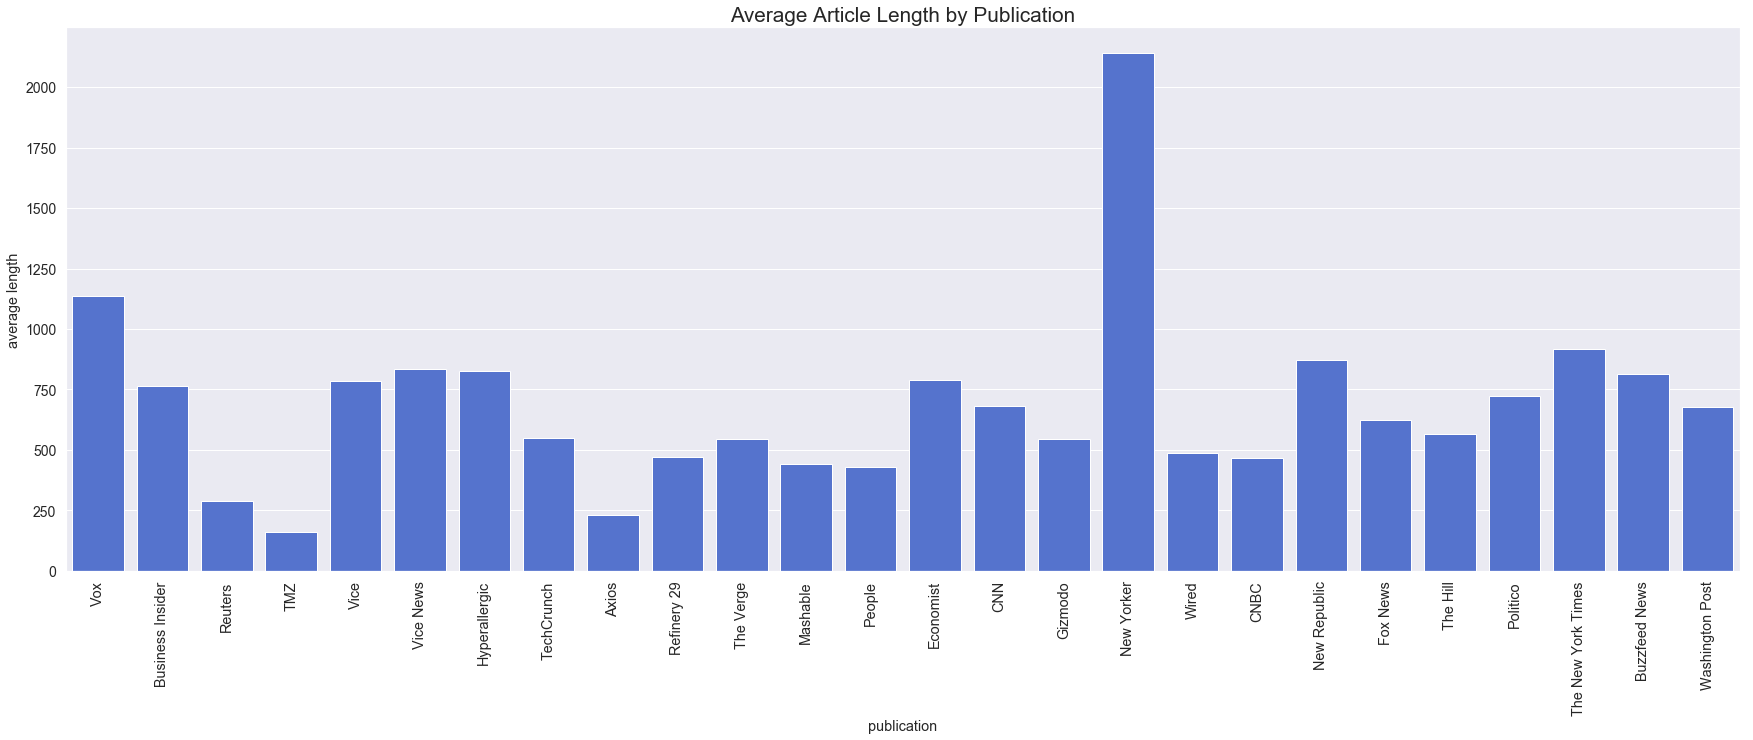

In [85]:
#plot average article length by publication
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

publications = [row['publication'] for row in avg_length_list]
avg_publications = [row['avg(article length)'] for row in avg_length_list]

publications_x,avg_publications_y = publications,avg_publications
fig,ax = plt.subplots(figsize=(30,10))
ax = sns.barplot(x=list(publications),y=list(avg_publications),color="royalblue")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize='large')
ax.tick_params(axis="y", labelsize='14')
plt.title('Average Article Length by Publication',fontsize='xx-large')
plt.xlabel('publication',fontsize='large')
plt.ylabel('average length',fontsize='large')
plt.show()

### Compare Article Lengths

In [13]:
min_article_len = df_art_len.select(min('article length'))
max_article_len = df_art_len.select(max('article length'))

min_article_len.show()
max_article_len.show()

+-------------------+
|min(article length)|
+-------------------+
|                  1|
+-------------------+

+-------------------+
|max(article length)|
+-------------------+
|              37598|
+-------------------+



In [8]:
#calculate percentiles
quantiles = df_art_len.approxQuantile('article length',[0.1,0.9],1/100000)
min_length = quantiles[0]
max_length = quantiles[1]

print('min article length: '+ str(min_length))
print('max article length: '+ str(max_length))

min article length: 77.0
max article length: 1077.0


In [9]:
#remove the lower and highest 10% article length
df_filtered = df_art_len.select('*').where((df_art_len['article length']>min_length) & (df_art_len['article length']<max_length))

In [16]:
#see how many articles remain after removing lowest and highest 10% of articles
df_filtered.count()

2064980

### Compare Number of Articles by Publication

In [1]:
#group number articles by publication
df_publications = df_filtered.groupBy('publication').count().orderBy('count',ascending = False)
publications_list =  df_publications.collect()


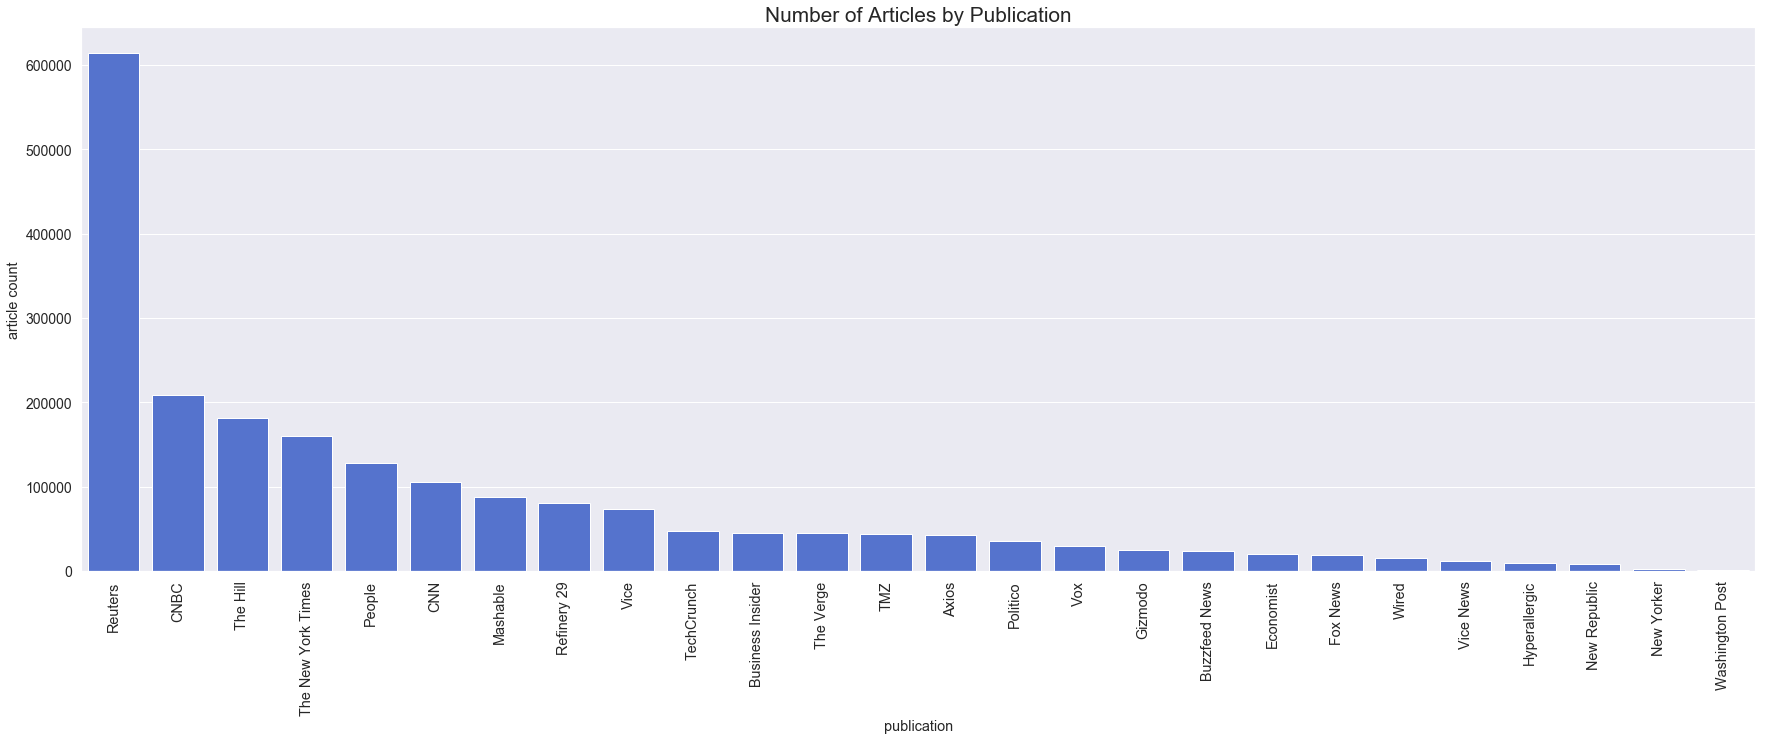

In [83]:
#plot number of articles by publication
sns.set()

publications = [row['publication'] for row in publications_list]
count_publications = [row['count'] for row in publications_list]

publications_x,count_publications_y = publications,count_publications
fig,ax = plt.subplots(figsize=(30,10))
ax = sns.barplot(x=list(publications),y=list(count_publications),color="royalblue")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize='large')
ax.tick_params(axis="y", labelsize='14')
plt.title('Number of Articles by Publication',fontsize='xx-large')
plt.xlabel('publication',fontsize='large')
plt.ylabel('article count',fontsize='large')
plt.show()

### Compare Number of Articles by Year

In [19]:
#calculate number of articles by year
year_df = df_filtered.groupBy('year').count().orderBy('year')
year_list = year_df.collect()
year_df.show()

+----+------+
|year| count|
+----+------+
|2016|466884|
|2017|487528|
|2018|441430|
|2019|520900|
|2020|148238|
+----+------+



In [ ]:
#plot number of articles by year
from matplotlib import pyplot as plt
import seaborn as sns

year = [row['year'] for row in year_list]
count_by_year = [row['count'] for row in year_list]

sns.set()
year_x,count_by_year_y = year,count_by_year
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=list(year_x),y=list(count_by_year),color="lightsteelblue")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,fontsize='large')
plt.title('Number of Articles by Year',fontsize='x-large')
plt.xlabel('year',fontsize='large')
plt.ylabel('article count',fontsize='large')
plt.show()

## Text Preprocessing

In [10]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
# transform all words to lower case and remove punctuation
df_lower = df_filtered.select('*', (lower(regexp_replace('article', "[^a-zA-Z\s]", ""))).alias('lower_text'))
df_lower.select('lower_text').show()                                    


+--------------------+
|          lower_text|
+--------------------+
| the indianapolis...|
|davos switzerland...|
|paris reuters  fo...|
|berlin june  reut...|
|caracas reuters  ...|
|google io the com...|
|china is dismissi...|
|reuters  the succ...|
|joakim noahs mode...|
|jermaine jackson ...|
|london reuters  b...|
|the nonpartisan d...|
|the threat of gov...|
| in the past girl...|
|before  isao taka...|
|brussels reuters ...|
|new york reuters ...|
|reuters  major au...|
|deontay wilder wa...|
|london reuters  b...|
+--------------------+
only showing top 20 rows



In [97]:
#tokenize articles
tokenizer = Tokenizer(inputCol='lower_text', outputCol='tokens_1')
df_tokens = tokenizer.transform(df_lower).select('article','tokens_1')
df_tokens = df_tokens.select('article',array_remove('tokens_1','').alias('tokens'))
print('Tokenized Text')
df_tokens.show()

#remove stop words
stop_remover = StopWordsRemover(inputCol='tokens', outputCol='tokens_nostop')
df_nostop = stop_remover.transform(df_tokens).select('article','tokens_nostop')
print('Tokenized Text - No Stop Words')
df_nostop.show()


Tokenized Text
+--------------------+--------------------+
|             article|              tokens|
+--------------------+--------------------+
| The Indianapolis...|[the, indianapoli...|
|DAVOS, Switzerlan...|[davos, switzerla...|
|PARIS (Reuters) -...|[paris, reuters, ...|
|BERLIN, June 17 (...|[berlin, june, re...|
|CARACAS (Reuters)...|[caracas, reuters...|
|Google I/O, the c...|[google, io, the,...|
|China is dismissi...|[china, is, dismi...|
|(Reuters) - The s...|[reuters, the, su...|
|Joakim Noah's ﻿mo...|[joakim, noahs, m...|
|Jermaine Jackson ...|[jermaine, jackso...|
|LONDON (Reuters) ...|[london, reuters,...|
|The nonpartisan d...|[the, nonpartisan...|
|The threat of gov...|[the, threat, of,...|
| In the past, Gir...|[in, the, past, g...|
|Before 2016, Isao...|[before, isao, ta...|
|BRUSSELS (Reuters...|[brussels, reuter...|
|NEW YORK (Reuters...|[new, york, reute...|
|(Reuters) - Major...|[reuters, major, ...|
|Deontay Wilder wa...|[deontay, wilder,...|
|LONDON (Reuters)

### Get Top 25 Words by Count

In [98]:
from pyspark.sql.functions import *

word_counts= df_nostop.select((explode('tokens_nostop')).alias('explode_tokens')).groupBy('explode_tokens').count().collect()
word_counts

[Row(explode_tokens='indianapolis', count=6424),
 Row(explode_tokens='colts', count=2565),
 Row(explode_tokens='made', count=651430),
 Row(explode_tokens='andrew', count=76294),
 Row(explode_tokens='luck', count=15293),
 Row(explode_tokens='highestpaid', count=1533),
 Row(explode_tokens='player', count=68736),
 Row(explode_tokens='nfl', count=41535),
 Row(explode_tokens='history', count=184399),
 Row(explode_tokens='offseason', count=4486),
 Row(explode_tokens='fiveyear', count=17190),
 Row(explode_tokens='million', count=932116),
 Row(explode_tokens='contract', count=71436),
 Row(explode_tokens='guaranteed', count=12650),
 Row(explode_tokens='however', count=311862),
 Row(explode_tokens='theyre', count=218601),
 Row(explode_tokens='already', count=348211),
 Row(explode_tokens='finding', count=57817),
 Row(explode_tokens='lucks', count=142),
 Row(explode_tokens='inhibiting', count=408),
 Row(explode_tokens='ability', count=98595),
 Row(explode_tokens='address', count=117907),
 Row(expl

In [99]:
words_dict = {row['explode_tokens']:row['count'] for row in word_counts}

In [100]:
#pos tagging
import nltk
words_pos = nltk.pos_tag(list(words_dict.keys()))

words_tup_list = list(zip(words_pos,words_dict.values()))
words_pos_count = [(w,pos,c) for (w,pos),c in words_tup_list] 

words_df = spark.createDataFrame(words_pos_count,['words','pos','count'])
words_df.show()


+------------+---+------+
|       words|pos| count|
+------------+---+------+
|indianapolis| NN|  6424|
|       colts|NNS|  2565|
|        made|VBN|651430|
|      andrew| JJ| 76294|
|        luck| NN| 15293|
| highestpaid|VBD|  1533|
|      player| NN| 68736|
|         nfl| JJ| 41535|
|     history| NN|184399|
|   offseason| NN|  4486|
|    fiveyear| JJ| 17190|
|     million| CD|932116|
|    contract| NN| 71436|
|  guaranteed|VBN| 12650|
|     however| RB|311862|
|      theyre| JJ|218601|
|     already| RB|348211|
|     finding|VBG| 57817|
|       lucks|NNS|   142|
|  inhibiting|VBG|   408|
+------------+---+------+
only showing top 20 rows



In [ ]:
#write words to csv file to increase runtime speed
words_df=words_df.repartition(2)
words_df.write\
.option("header",'true')\
.csv("words_df.csv")

In [101]:
# #stem words
from nltk import PorterStemmer

stemmer = PorterStemmer()
stem_udf = udf(lambda t: stemmer.stem(t))
df_stemmed = words_df.withColumn('words_stemmed',stem_udf('words')).select('words','words_stemmed','count')
df_stemmed.show()


+------------+-------------+------+
|       words|words_stemmed| count|
+------------+-------------+------+
|indianapolis|  indianapoli|  6424|
|       colts|         colt|  2565|
|        made|         made|651430|
|      andrew|       andrew| 76294|
|        luck|         luck| 15293|
| highestpaid|  highestpaid|  1533|
|      player|       player| 68736|
|         nfl|          nfl| 41535|
|     history|      histori|184399|
|   offseason|    offseason|  4486|
|    fiveyear|     fiveyear| 17190|
|     million|      million|932116|
|    contract|     contract| 71436|
|  guaranteed|     guarante| 12650|
|     however|        howev|311862|
|      theyre|        theyr|218601|
|     already|      alreadi|348211|
|     finding|         find| 57817|
|       lucks|         luck|   142|
|  inhibiting|      inhibit|   408|
+------------+-------------+------+
only showing top 20 rows



In [ ]:
#total vocabulary
df_stemmed.select('words_stemmed').distinct().count()

In [102]:
#order the words by count and get top 25 words
top25_words = df_stemmed.groupBy('words_stemmed').agg({'count':'sum'}).orderBy('sum(count)',ascending=False).take(25)

In [ ]:
top25_words

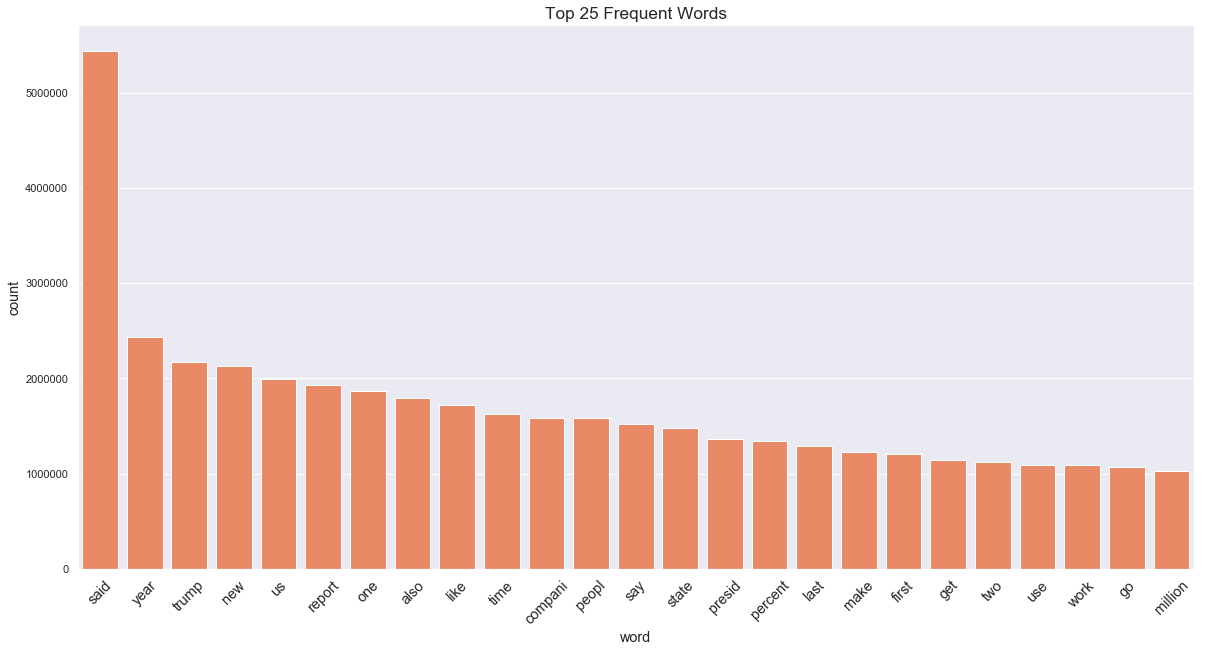

In [103]:
#Plot top 25 words
from matplotlib import pyplot as plt
import seaborn as sns

words_top25 = [row['words_stemmed'] for row in top25_words]
count_top25 = [row['sum(count)'] for row in top25_words]

words,freq = words_top25,count_top25
fig,ax = plt.subplots(figsize=(20,10))
fig
ax = sns.barplot(x=list(words),y=list(freq),color="coral")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,fontsize='large')
plt.xlabel('word',fontsize='large')
plt.ylabel('count',fontsize='large')
plt.title('Top 25 Frequent Words',fontsize='x-large')
plt.show()


## Get Top 25 Bigrams by Count

In [46]:
#create bigrams
from pyspark.ml.feature import NGram
#create bigrams using tokens from articles
bigrams_df = NGram(n=2,inputCol='tokens_nostop', outputCol='bigrams').transform(df_nostop).select('article','bigrams')

In [47]:
# get all bigrams in articles and count bigrams
bigrams_df = bigrams_df.repartition(2)
bigrams_df_explode = bigrams_df.select(explode('bigrams').alias('explode_bigrams')).groupBy('explode_bigrams').count()
bigrams_df_explode.show()


+--------------------+------+
|     explode_bigrams| count|
+--------------------+------+
|          draws tens|   675|
|             tel fax|180337|
|       neck penavega|     1|
|     like meditation|    86|
|      gates admitted|    68|
|         ever paying|    30|
|      cash ukrainian|     2|
|       lawyer thomas|   151|
|       meaning gates|     1|
|        agrees smash|     1|
|      naturally word|     4|
|    difference three|    71|
|    making desperate|    56|
|           two sides| 12517|
|       disclose size|   198|
|        us estimates|    82|
|   determine charges|    49|
|discrepancies prices|     2|
|    february request|    34|
|         us citizens|  6527|
+--------------------+------+
only showing top 20 rows



In [48]:
#order top bigrams by count and keep top 25
top25_bigrams = bigrams_df_explode.orderBy('count',ascending=False).take(25)

In [ ]:
top25_bigrams

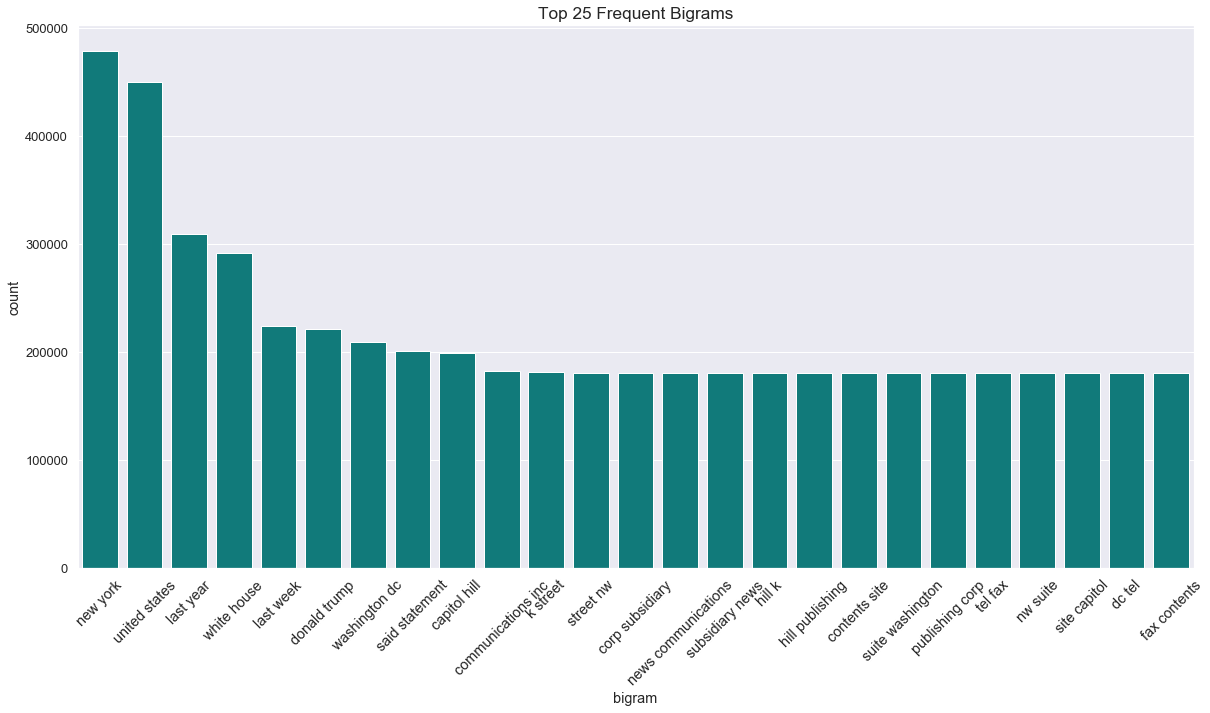

In [78]:
#plot top 25 bigrams by count
from matplotlib import pyplot as plt
import seaborn as sns

bigrams_top25 = [row['explode_bigrams'] for row in top25_bigrams]
bcount_top25 = [row['count'] for row in top25_bigrams]

words,freq = bigrams_top25,bcount_top25
fig,ax = plt.subplots(figsize=(20,10))
fig
ax = sns.barplot(x=list(words),y=list(freq),color="darkcyan")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,fontsize='large')
ax.tick_params(axis="y", labelsize='13')
plt.xlabel('bigram',fontsize='large')
plt.ylabel('count',fontsize='large')
plt.title('Top 25 Frequent Bigrams',fontsize='x-large')
plt.show()

## Find Top 25 Words and Bigrams by Count - Remove advertisements
- Repeat the same analysis as above
- The top 25 words and bigrams contained words from advertisements since they appear frequently in some publications' articles

- Method: Remove sentences that occur more than 3 times and has a length of at least 3 words as the exact same sentence should not occur in articles frequently

In [ ]:
df_lower_2 = df_filtered.select('article', (lower('article')).alias('lower_text_2'))

In [ ]:
#sentence tokenize each article to be able to count sentences

sent_udf = udf(lambda row: nltk.sent_tokenize(row))
makelist_udf = udf(lambda x: x,ArrayType(StringType()))
df_sent = df_lower_2.withColumn('col',sent_udf(col('lower_text_2')))\
        .withColumn('sent_tokens',makelist_udf('col'))\
        .select('article','sent_tokens')

In [ ]:
#count frequency of each sentence
df_sent_explode = df_sent.select(explode('sent_tokens').alias('sent_explode')).groupBy('sent_explode').count()

In [ ]:
#order sentences by frequency in descending order
df_sent_ordered = df_sent_explode.repartition(2).orderBy('count',ascending=False)

In [ ]:
df_sent_ordered.take(20)

In [ ]:
#remove sentences that occur more than 3 times and have a length of at least 3 words
#this should filter out the majority of publication advertisements
df_sent_filtered = df_sent_ordered.select('sent_explode',length('sent_explode').alias('sent_length'),'count').where((col('sent_length')>=3) & (col('count')<=2))
df_sent_filtered.show()

In [1]:
#reimport dataset to increase speed - avoid dataset being recalculated every time
df_sent_filtered=df_sent_filtered.repartition(2)
df_sent_filtered.write\
.option("header",'true')\
.csv("df_filtered_sent.csv")

In [34]:
df_sent_new = spark.read\
  .option("header", "true")\
  .csv("df_filtered_sent.csv")


df_sent_new.select('sent_explode').show()

+--------------------+
|        sent_explode|
+--------------------+
|trump vowed in th...|
|that didn’t work ...|
|seoul (reuters) -...|
|considers him low...|
|japanese prime mi...|
|- ventilators are...|
|however, analysts...|
|alexandria ocasio...|
|“market participa...|
|a part of the new...|
|other risks, incl...|
|read more: a bbc ...|
|“osram’s shares s...|
|new cars are for ...|
|even if they do n...|
|warmbier’s parent...|
|the date aligns t...|
|“in addition to s...|
|trump also said h...|
|so now the summit...|
+--------------------+
only showing top 20 rows



### Repeat Text Preprocessing Steps using Filtered Dataset with Ads Removed

In [35]:
#remove punctuation
df_sent_nopunc = df_sent_new.select('sent_explode', (regexp_replace('sent_explode', "[^a-zA-Z\s]", "")).alias('nopunc_text'))
df_sent_nopunc = df_sent_nopunc.where(length('nopunc_text')>0)
print ('No Punctuation Text')
df_sent_nopunc.show()

#tokenize articles
tokenizer2 = Tokenizer(inputCol='nopunc_text', outputCol='tokens_1')
#tokenizer.transform(df.na.drop(Array("description")))
df_sent_tokens = tokenizer2.transform(df_sent_nopunc).select('sent_explode','tokens_1')
df_sent_tokens = df_sent_tokens.select('sent_explode',array_remove('tokens_1','').alias('tokens'))
print('Tokenized Text')
df_sent_tokens.show()

#remove stop words
stop_remover2 = StopWordsRemover(inputCol='tokens', outputCol='tokens_nostop')
df_sent_nostop = stop_remover2.transform(df_sent_tokens).select('sent_explode','tokens_nostop')
print('Tokenized Text - No Stop Words')
df_sent_nostop.show()



No Punctuation Text
+--------------------+--------------------+
|        sent_explode|         nopunc_text|
+--------------------+--------------------+
|trump vowed in th...|trump vowed in th...|
|that didn’t work ...|that didnt work o...|
|seoul (reuters) -...|seoul reuters  so...|
|considers him low...|considers him low...|
|japanese prime mi...|japanese prime mi...|
|- ventilators are...| ventilators are ...|
|however, analysts...|however analysts ...|
|alexandria ocasio...|alexandria ocasio...|
|“market participa...|market participan...|
|a part of the new...|a part of the new...|
|other risks, incl...|other risks inclu...|
|read more: a bbc ...|read more a bbc c...|
|“osram’s shares s...|osrams shares see...|
|new cars are for ...|new cars are for ...|
|even if they do n...|even if they do n...|
|warmbier’s parent...|warmbiers parents...|
|the date aligns t...|the date aligns t...|
|“in addition to s...|in addition to sw...|
|trump also said h...|trump also said h...|
|so now the 

In [36]:
#get word counts 
df_sent_nostop = df_sent_nostop.select('tokens_nostop').filter(size('tokens_nostop')>0) #filter out blank lists
word_counts_new= df_sent_nostop.select((explode('tokens_nostop')).alias('explode_sent_tokens')).groupBy('explode_sent_tokens').count()
word_counts_new.show()

+-------------------+------+
|explode_sent_tokens| count|
+-------------------+------+
|             online|180402|
|             brands| 62889|
|          recognize| 29418|
|              still|596072|
|               hope|120662|
|          standards| 50579|
|            jewelry| 12382|
|           priority| 31957|
|           cautious| 16016|
|             travel|107015|
|         electrical|  7941|
|            clinics|  8032|
|              hanna|  2007|
|                art|108193|
|    lautenschlaeger|   302|
|        transaction| 23549|
|         occidental|  2102|
|          connected| 36826|
|             tonnes| 34043|
|             harder| 36142|
+-------------------+------+
only showing top 20 rows



In [ ]:
word_counts_new.count()

In [38]:
#stem words
word_counts_new = word_counts_new.repartition(2)
stemmer = PorterStemmer()
stem_udf = udf(lambda t: stemmer.stem(t))
df_stemmed_new = word_counts_new.withColumn('words_stemmed_new',stem_udf('explode_sent_tokens')).select('words_stemmed_new','count')
df_stemmed_new.show()


+--------------------+-----+
|   words_stemmed_new|count|
+--------------------+-----+
|           rarelybut|    1|
|            growthev|    1|
|               ofcgi|    1|
|               tsasc|    2|
|pictwittercomvpre...|    1|
|        seaislechamb|    2|
|           medsmight|    1|
|             itlimit|    1|
|         commentsnot|    1|
|        americanatyp|    1|
|           guardthat|    5|
|        thecinnabons|    1|
|          tommyraket|    1|
|          streamwhil|    1|
| awednesdayinstagram|    1|
|                toct|    1|
|            arenafar|    1|
| pictwittercomhczkch|    1|
|            junquito|    2|
|                 itt|  510|
+--------------------+-----+
only showing top 20 rows



In [39]:
#group stemmed words by count
df_stemmed_new_agg = df_stemmed_new.groupBy('words_stemmed_new').agg({'count':'sum'})

In [40]:
#sort stemmed words by count to get top 25 most frequent words
top25_words_new = df_stemmed_new_agg.orderBy('sum(count)',ascending=False).take(25)
top25_words_new

[Row(words_stemmed_new='said', sum(count)=4629493),
 Row(words_stemmed_new='year', sum(count)=2137980),
 Row(words_stemmed_new='trump', sum(count)=2011495),
 Row(words_stemmed_new='new', sum(count)=1892785),
 Row(words_stemmed_new='one', sum(count)=1729760),
 Row(words_stemmed_new='us', sum(count)=1663710),
 Row(words_stemmed_new='also', sum(count)=1603755),
 Row(words_stemmed_new='like', sum(count)=1600471),
 Row(words_stemmed_new='report', sum(count)=1546286),
 Row(words_stemmed_new='time', sum(count)=1474058),
 Row(words_stemmed_new='peopl', sum(count)=1437828),
 Row(words_stemmed_new='say', sum(count)=1401845),
 Row(words_stemmed_new='compani', sum(count)=1380212),
 Row(words_stemmed_new='state', sum(count)=1292718),
 Row(words_stemmed_new='presid', sum(count)=1223026),
 Row(words_stemmed_new='percent', sum(count)=1184979),
 Row(words_stemmed_new='make', sum(count)=1129590),
 Row(words_stemmed_new='last', sum(count)=1124344),
 Row(words_stemmed_new='first', sum(count)=1108015),
 Ro

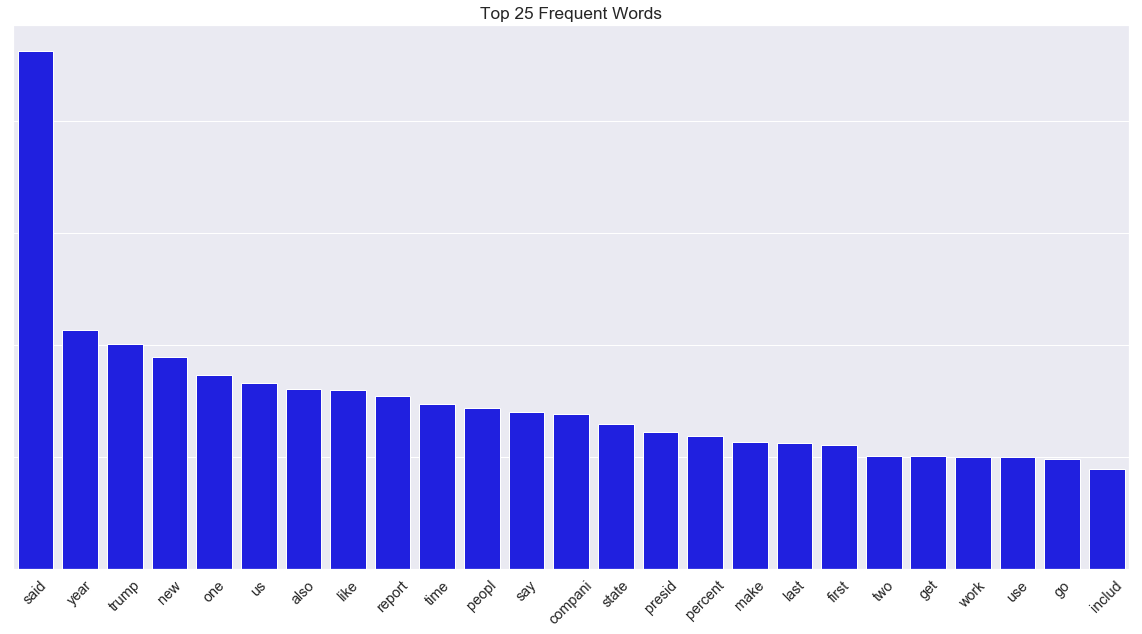

In [41]:
#plot top 25 words by count
from matplotlib import pyplot as plt
import seaborn as sns

new_word_top25 = [row['words_stemmed_new'] for row in top25_words_new]
new_word_count_top25 = [row['sum(count)'] for row in top25_words_new]

words,freq = new_word_top25, new_word_count_top25
fig,ax = plt.subplots(figsize=(20,10))
fig
ax = sns.barplot(x=list(words),y=list(freq),color="blue")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,fontsize='large')
ax.set_yticklabels(ax.get_yticklabels(),fontsize='large')
plt.title('Top 25 Frequent Words',fontsize='x-large')
plt.show()

### Get Top 25 Bigrams - Ads Removed

In [42]:
#create bigrams
from pyspark.ml.feature import NGram
bigrams_df_new = NGram(n=2,inputCol='tokens_nostop', outputCol='bigrams_new').transform(df_sent_nostop).select('tokens_nostop','bigrams_new')

In [43]:
#group bigrams by count
bigrams_df_new = bigrams_df_new.repartition(2)
bigrams_df_explode_new = bigrams_df_new.select(explode('bigrams_new').alias('explode_bigrams_new')).groupBy('explode_bigrams_new').count()
bigrams_df_explode_new.show()


+--------------------+-----+
| explode_bigrams_new|count|
+--------------------+-----+
|   advantage brazils|    2|
|   regulated sectors|   21|
|expending conside...|    3|
|      sobriety tests|  113|
|      locales varied|    5|
|         songs trump|   13|
|republican candidate| 3226|
|    reluctant accept|  114|
|part informationg...|    3|
|      ethiopian birr|   20|
|     business global|  175|
|         average per| 1370|
|  charge arraignment|    2|
|       full recovery| 1106|
|          true banks|   15|
|      scott schenkel|   17|
|     chief financial|12141|
|       onshore shale|   95|
|        science said|  396|
|       mohammad reza|   99|
+--------------------+-----+
only showing top 20 rows



In [44]:
#order bigrams by count and get top 25 most frequent bigrams
top25_bigrams_new = bigrams_df_explode_new.orderBy('count',ascending=False).take(25)
top25_bigrams_new

[Row(explode_bigrams_new='new york', count=418579),
 Row(explode_bigrams_new='united states', count=365991),
 Row(explode_bigrams_new='white house', count=268074),
 Row(explode_bigrams_new='last year', count=265776),
 Row(explode_bigrams_new='donald trump', count=197992),
 Row(explode_bigrams_new='last week', count=192303),
 Row(explode_bigrams_new='said statement', count=169818),
 Row(explode_bigrams_new='president donald', count=135692),
 Row(explode_bigrams_new='last month', count=129517),
 Row(explode_bigrams_new='social media', count=125455),
 Row(explode_bigrams_new='first time', count=115756),
 Row(explode_bigrams_new='prime minister', count=107335),
 Row(explode_bigrams_new='los angeles', count=93168),
 Row(explode_bigrams_new='trump administration', count=92055),
 Row(explode_bigrams_new='years ago', count=91703),
 Row(explode_bigrams_new='per share', count=86765),
 Row(explode_bigrams_new='president trump', count=86445),
 Row(explode_bigrams_new='chief executive', count=84705

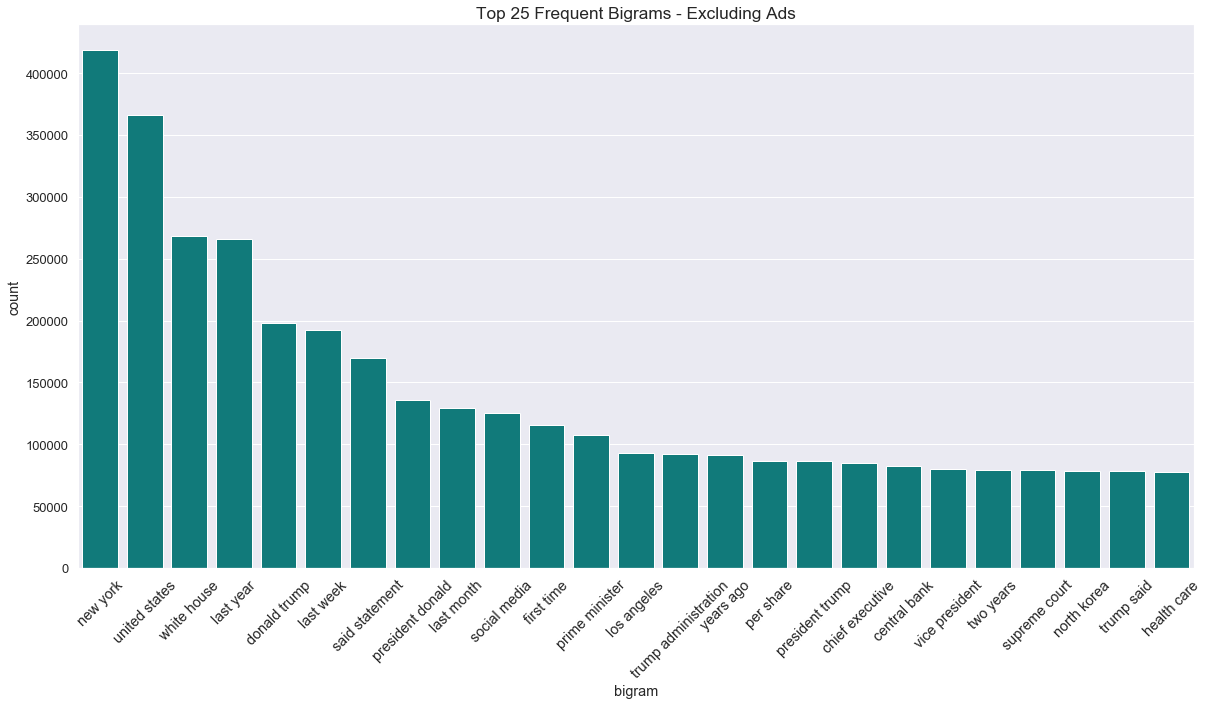

In [79]:
#plot top 25 bigrams by count
from matplotlib import pyplot as plt
import seaborn as sns

bigrams_top25_new = [row['explode_bigrams_new'] for row in top25_bigrams_new]
bcount_top25_new = [row['count'] for row in top25_bigrams_new]

words,freq = bigrams_top25_new,bcount_top25_new
fig,ax = plt.subplots(figsize=(20,10))
fig
ax = sns.barplot(x=list(words),y=list(freq),color="darkcyan")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,fontsize='large')
ax.tick_params(axis="y", labelsize='13')
plt.xlabel('bigram',fontsize='large')
plt.ylabel('count',fontsize='large')
plt.title('Top 25 Frequent Bigrams - Excluding Ads',fontsize='x-large')
plt.show()